In [0]:
%cd
%tensorflow_version 1.x

import os
import zipfile 
import tensorflow as tf

from google.colab import drive

print(tf.__version__)

!pip install -q PyDrive
!git clone --quiet https://github.com/WimFlorijn/Mask-RCNN.git

%cd ~/Mask-RCNN

drive.mount('/content/gdrive')

/root
1.15.2
/root/Mask-RCNN
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
zip_ref = zipfile.ZipFile("/content/gdrive/My Drive/train_data.zip", 'r')
zip_ref.extractall("/tmp/traindata")
zip_ref.close()

print(os.listdir('/tmp/traindata'))

['VW_TLO00_B_00728_000002350', 'VW_CVD00_C_00431_000006514', 'VW_HNO02_H_00308_000000523', 'VW_LRN01_C_00283_000006134', 'VW_VKB03_A_00149_000000368', 'VW_DTC02_B_00257_000000298', 'VW_LNK00_Q_01081_000016546', 'VW_LPS00_A_00450_000003050', 'VW_HNO02_G_00165_000001237', 'VW_LRN01_D_00323_000004628', 'VW_BRC00_E_00023_000001826', 'VW_FNK00_B_00418_000003594', 'VW_VKB03_A_00148_000000367', 'VW_BRC00_D_00643_000003782', 'VW_HVR00_L_00355_000002893', 'VW_TSL00_A_00349_000002045', 'VW_DNK00_G_00780_000007585', 'VW_HVR00_E_00294_000001400', 'VW_OWD00_B_01231_000004523', 'VW_TEL00_A_00599_000008819', 'VW_UQT00_D_00025_000001098', 'VW_BRC00_D_00566_000003702', 'VW_SNE00_A_00145_000006364', 'VW_BRC00_E_01233_000003060', 'VW_HNO02_D_00109_000001917', 'VW_CVD00_C_00145_000006224', 'VW_BER02_L_00132_000002872', 'VW_HNO02_G_00430_000001511', 'VW_BER02_L_00152_000002892', 'VW_SNE00_A_00201_000006422', 'VW_BIL01_E_01277_000007603', 'VW_APG00_G_00894_000004644', 'VW_APG00_G_01374_000005220', 'VW_BRC00

In [0]:
import re
import sys
import cv2
import math
import time
import random
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)
import mrcnn.model as modellib

from mrcnn import utils
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.config import Config

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = '/content/gdrive/My Drive/snapshot'

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


... done downloading pretrained model!


In [0]:
class SketchConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "sketch"

    BACKBONE='resnet50'
    
    SAVE_INTERVAL = 2
    USE_MINI_MASK = True

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 4 variants

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 768
    IMAGE_MAX_DIM = 1280

    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7

    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3
    
    # Percent of positive ROIs used to train classifier/mask heads
    ROI_POSITIVE_RATIO = 0.33

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 24, 32, 40)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 400

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 200

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = SketchConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1280
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  768
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1280 1280    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [0]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [0]:
class SketchDataset(utils.Dataset):

    def load_sketch(self, image_ids):
        self.add_class("sketch", 1, "measurement")
        self.add_class("sketch", 2, "parcel_number")
        # self.add_class("sketch", 3, "building")
        # self.add_class("sketch", 4, "line")

        for image_id in image_ids:
          path = os.path.join(dataset_dir, image_id, "image.png")
          self.add_image("sketch", image_id=image_id, path=path)

    def load_mask(self, image_id):
        # Get mask directory from image path
        dataset_dir = '/tmp/traindata'
        
        info = self.image_info[image_id]
        
        # Get mask directory from image path
        mask_dirs = ['measurement_masks', 'parcel_number_masks']
        # 'building_masks', 'line_masks', 
        
        # Read mask files from .png image
        masks, labels = [], []
        for i, name in enumerate(mask_dirs):
            mask_dir = os.path.join(dataset_dir, os.path.dirname(info['path']), name)
            if os.path.exists(mask_dir) and len(os.listdir(mask_dir)) != 0:
                for f in next(os.walk(mask_dir))[2]:
                    mask_img=np.zeros((config.IMAGE_MAX_DIM, config.IMAGE_MIN_DIM), dtype=np.uint8)
                    m = np.load(os.path.join(mask_dir, f))
                    mask_img[m[0], m[1]] = 1
                    masks.append(mask_img)
                    labels.append(i + 1)
        
        if len(masks):
            masks = np.stack(masks, axis=-1)
            labels = np.asarray(labels, dtype=np.int32)
        else:
            masks = np.zeros((config.IMAGE_MAX_DIM, config.IMAGE_MIN_DIM, 0),dtype=np.uint8)
            labels = np.array([])

        return masks, labels

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "sketch":
            return info["id"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [0]:
dataset_dir = '/tmp/traindata'
image_ids = next(os.walk(dataset_dir))[1]

# Add images
random.shuffle(image_ids)

image_ids_length = len(image_ids)
split = int(image_ids_length * .95)
train_ids, val_ids = image_ids[:split], image_ids[split:]

# Training dataset
dataset_train = SketchDataset()
dataset_train.load_sketch(train_ids)
dataset_train.prepare()

# Validation dataset
dataset_val = SketchDataset()
dataset_val.load_sketch(val_ids)
dataset_val.prepare()

1844


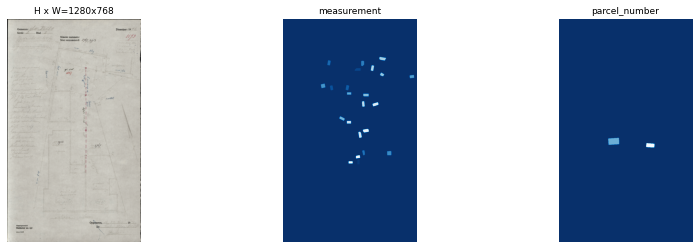

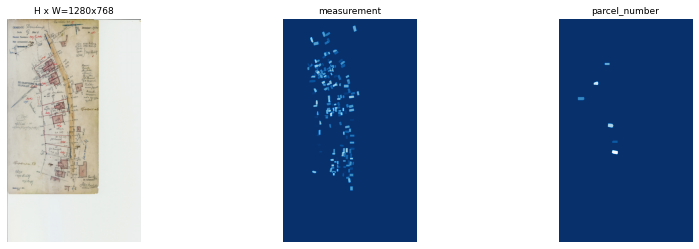

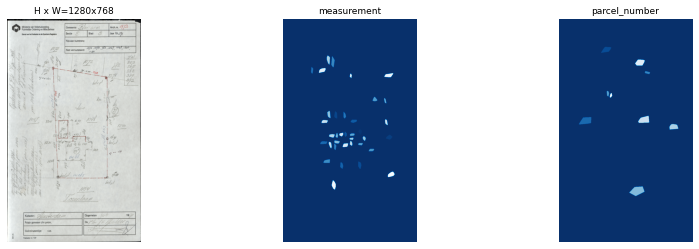

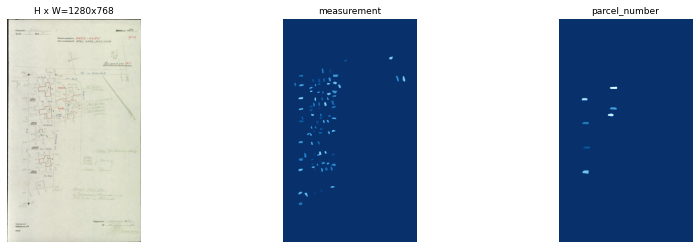

In [0]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids,
                                dataset_train.class_names, limit=2)

In [0]:
# Create model in training mode
try:
    del model
except:
    pass

model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [0]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [0]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13005214292678865143, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 192976202806759133
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4398901773935826724
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7470045594
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18085618190683418960
 physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1"]

In [0]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
# early_stopping = keras.callbacks.callbacks.EarlyStopping(
#     monitor='val_loss', min_delta=0, patience=5, verbose=0,
#     restore_best_weights=True)

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE,
            epochs=300, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/gdrive/My Drive/snapshot/sketch20200326T2234/mask_rcnn_sketch_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrc

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple 

Epoch 1/300
 49/200 [======>.......................] - ETA: 14:06 - loss: 2.8946 - rpn_class_loss: 0.3706 - rpn_bbox_loss: 0.9183 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.8164 - mrcnn_mask_loss: 0.7093

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:709: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


200/200 [==============================] - 989s 5s/step - loss: 2.2575 - rpn_class_loss: 0.1921 - rpn_bbox_loss: 0.8341 - mrcnn_class_loss: 0.1247 - mrcnn_bbox_loss: 0.5587 - mrcnn_mask_loss: 0.5479 - val_loss: 2.0333 - val_rpn_class_loss: 0.1772 - val_rpn_bbox_loss: 0.9518 - val_mrcnn_class_loss: 0.1059 - val_mrcnn_bbox_loss: 0.3866 - val_mrcnn_mask_loss: 0.4118

Epoch 2/300
200/200 [==============================] - 702s 4s/step - loss: 1.8367 - rpn_class_loss: 0.1095 - rpn_bbox_loss: 0.7550 - mrcnn_class_loss: 0.1917 - mrcnn_bbox_loss: 0.3743 - mrcnn_mask_loss: 0.4062 - val_loss: 1.5113 - val_rpn_class_loss: 0.0831 - val_rpn_bbox_loss: 0.7225 - val_mrcnn_class_loss: 0.1200 - val_mrcnn_bbox_loss: 0.2631 - val_mrcnn_mask_loss: 0.3224
Epoch 3/300
200/200 [==============================] - 564s 3s/step - loss: 1.6756 - rpn_class_loss: 0.0663 - rpn_bbox_loss: 0.6879 - mrcnn_class_loss: 0.2256 - mrcnn_bbox_loss: 0.3344 - mrcnn_mask_loss: 0.3614 - val_loss: 1.3677 - val_rpn_class_loss: 0.0

In [0]:
class InferenceConfig(SketchConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /root/logs/sketch20200326T1306/mask_rcnn_sketch_0005.h5
Re-starting from epoch 5


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 1128.00000  int64
gt_class_id              shape: (29,)                 min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (29, 4)               min:  323.00000  max:  830.00000  int32
gt_mask                  shape: (1024, 1024, 29)      min:    0.00000  max:    1.00000  uint8


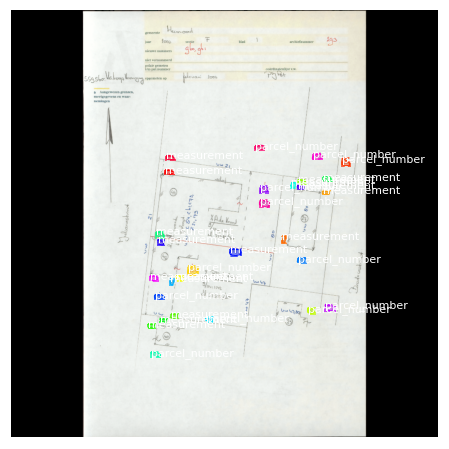

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


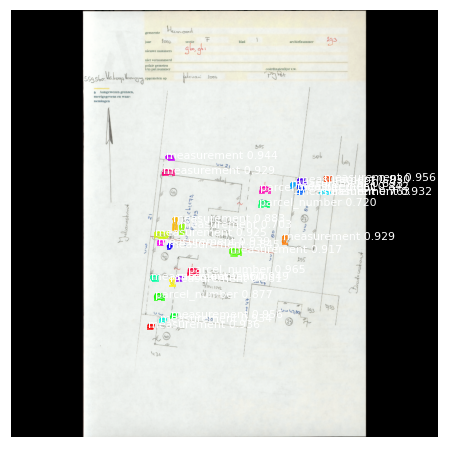

In [0]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))



results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

